<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_landuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carli Beisel

September 16, 2024

Purpose: Identify urban proportion and crop type in each reach within Mason

## Urbanization

In [1]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio
import rasterio.features
from rasterio import mask
from rasterio.crs import CRS
from shapely.geometry import box
import glob
import os
import json

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.7 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# --------------- #
#   Load Files    #
# --------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
cdl = rasterio.open('/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif')
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

In [3]:
# --------------- #
# Area of each reach
# --------------- #


reaches = reaches.to_crs(epsg=5070)

reaches['area_m2'] = reaches.geometry.area
reaches['area_mi2'] = reaches['area_m2'] / 2_589_988.11  # Conversion to miles

reach_areas_mi2 = reaches[['Reach', 'area_mi2']]
print("Area in square miles:")
print(reach_areas_mi2)

Area in square miles:
           Reach  area_mi2
0    Noble Drain  3.728043
1   Purdum Reach  1.693426
2  Solomon Reach  3.436166
3        Reach 1  3.898848
4        Reach 2  5.021585
5        Reach 3  0.831347


In [4]:
## ------------------------------ ##
##  Mask CDL Layer to Each Reach  ##
## ------------------------------ ##

# Load the shapefile and raster
shapefile_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp'
raster_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif'
output_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023'

# Read shapefile and raster
shp_file = gpd.read_file(shapefile_path)
with rasterio.open(raster_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Shapefile CRS: {shp_file.crs}")

    # Reproject the shapefile to match raster CRS
    shp_file = shp_file.to_crs(src.crs)

    # Explicitly use mask function
    mask_function = rasterio.mask.mask

    # Loop through each geometry and mask the raster
    for i, row in shp_file.iterrows():
        try:
            # Use geometry directly
            geometry = [row['geometry'].__geo_interface__]

            # Ensure geometry intersects the raster
            if not row['geometry'].intersects(box(*src.bounds)):
                print(f"Geometry '{row['Reach']}' does not intersect raster. Skipping...")
                continue

            # Mask raster
            out_img, out_transform = mask_function(src, shapes=geometry, crop=True, nodata=0)

            # Update metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_img.shape[1],
                "width": out_img.shape[2],
                "transform": out_transform,
                "nodata": 0
            })

            # Save the masked raster
            feature_name = row['Reach']
            out_filename = os.path.join(output_dir, f"{feature_name}.tif")
            with rasterio.open(out_filename, 'w', **out_meta) as dest:
                dest.write(out_img[0], 1)

            print(f"Saved cropped raster for '{feature_name}' to {out_filename}")

        except Exception as e:
            print(f"Error processing '{row['Reach']}': {e}")

Raster CRS: EPSG:5070
Shapefile CRS: EPSG:4326
Saved cropped raster for 'Noble Drain' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Noble Drain.tif
Saved cropped raster for 'Purdum Reach' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Purdum Reach.tif
Saved cropped raster for 'Solomon Reach' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Solomon Reach.tif
Saved cropped raster for 'Reach 1' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 1.tif
Saved cropped raster for 'Reach 2' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 2.tif
Saved cropped raster for 'Reach 3' to /content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/Reach 3.tif


In [5]:
# ---------------------------- #
#    Characterization: Urban
# ---------------------------- #
masked_cdl_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023'
reach_shapefile = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp'

# Load the reach shapefile and ensure it's projected to EPSG:5070
gdf_reaches = gpd.read_file(reach_shapefile)
if gdf_reaches.crs is not None and gdf_reaches.crs.to_epsg() != 5070:
    gdf_reaches = gdf_reaches.to_crs(epsg=5070)

# Compute area in square miles
gdf_reaches['area_mi2'] = gdf_reaches.geometry.area / 2_589_988.11

# Create a dictionary mapping reach names to their areas
reach_area_dict = gdf_reaches.set_index('Reach')['area_mi2'].to_dict()

# Define crop types for urban land
developed_crop_types = {82, 121, 122, 123, 124}

data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))

for file_path in masked_files:  # Loop through each reach
    reach_name = os.path.basename(file_path).replace('.tif', '')  # Extract reach name from the file name
    print(f'Processing file for reach: {reach_name}')

    # Retrieve the area of the reach from the dictionary
    reach_area_mi2 = reach_area_dict.get(reach_name)
    if reach_area_mi2 is None:
        print(f"Warning: Reach {reach_name} not found in shapefile, skipping...")
        continue

    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)

        # Count pixels for each urbanization type
        urban_pixel_counts = {ct: 0 for ct in developed_crop_types}
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            if crop_type in developed_crop_types:
                urban_pixel_counts[crop_type] += count

        # Calculate urban areas in square miles
        pixel_area = src.res[0] * src.res[1] / 2_589_988.11  # Convert pixel area to square miles
        urban_areas = {crop: count * pixel_area for crop, count in urban_pixel_counts.items()}

        # Calculate proportion of developed land using the shapefile's reach area
        developed_area_mi2 = sum(urban_areas.values())
        percent_developed = (100 * developed_area_mi2 / reach_area_mi2) if reach_area_mi2 > 0 else 0

        # Append the data for this reach
        data.append({
            'Reach': reach_name,
            'Reach Area(mi²)': reach_area_mi2,
            'Urban Area (mi²)': developed_area_mi2,
            'High Density Urban (mi²)': urban_areas.get(124, 0),
            'Medium Density Urban (mi²)': urban_areas.get(123, 0),
            'Low Density Urban (mi²)': urban_areas.get(122, 0),
            'Open Space Urban (mi²)': urban_areas.get(121, 0),
            'Urban Percent': percent_developed
        })

urban = pd.DataFrame(data)
urban.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv', index=False)

Processing file for reach: Noble Drain
Processing file for reach: Reach 2
Processing file for reach: Solomon Reach
Processing file for reach: Reach 1
Processing file for reach: Purdum Reach
Processing file for reach: Reach 3


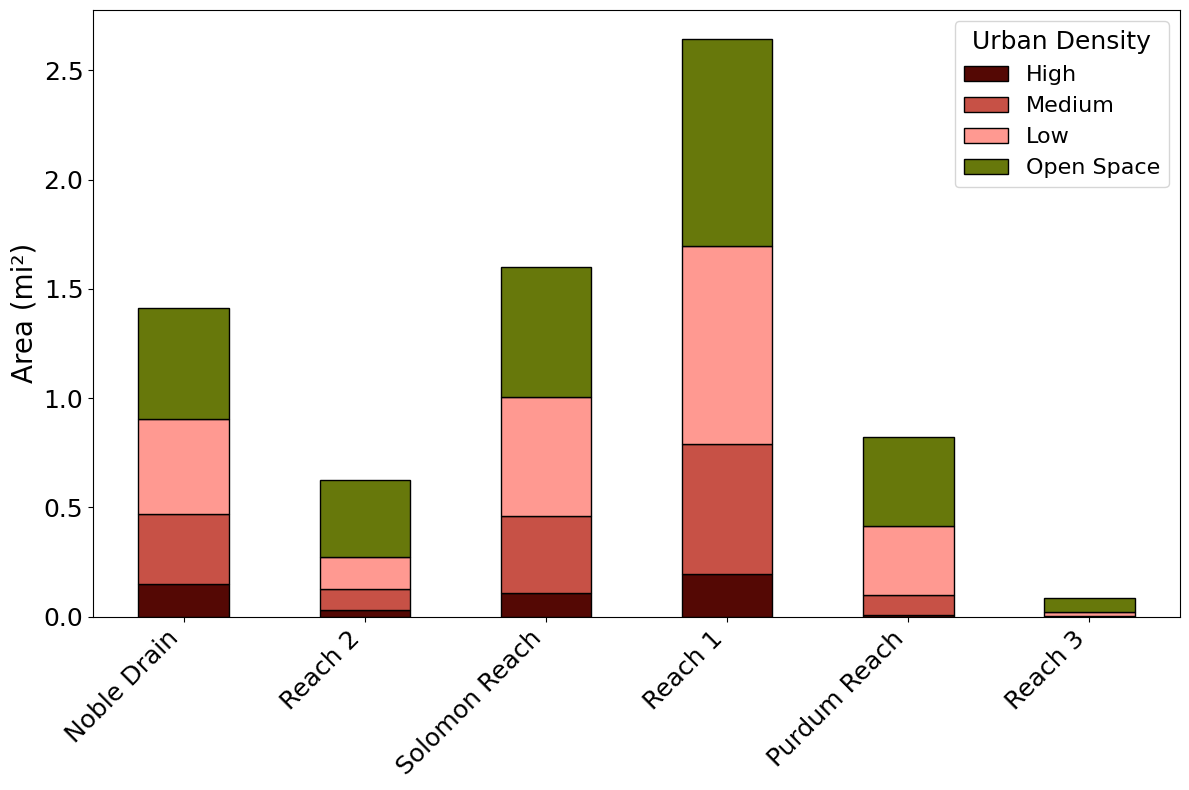

In [6]:
# ----------------------------------------- #
# FIGURE: Type of Urbanization in each reach
# ----------------------------------------- #

# Rename columns for legend labels
legend_labels = {
    'High Density Urban (mi²)': 'High',
    'Medium Density Urban (mi²)': 'Medium',
    'Low Density Urban (mi²)': 'Low',
    'Open Space Urban (mi²)': 'Open Space'
}

plot_data = urban.set_index('Reach')
plot_data = plot_data[list(legend_labels.keys())]  # Ensure correct order
plot_data = plot_data.rename(columns=legend_labels)  # Rename columns

# Custom colors for urban area
custom_colors = {
    'High': '#540804',
    'Medium': '#C75146',
    'Low': '#FF9991',
    'Open Space': '#67780B'
}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
plot_data.plot(
    kind='bar',
    stacked=True,
    color=[custom_colors[col] for col in plot_data.columns],
    edgecolor='black',
    ax=ax
)

plt.title('', fontsize=20, pad=15)
plt.ylabel('Area (mi²)', fontsize=20)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(
    title='Urban Density',
    loc='upper right',
    fontsize=16,
    title_fontsize=18
)
plt.tight_layout()

plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/Figures/reach urban area.png', dpi=300, bbox_inches='tight')
plt.close()

## Crops, pasture, and urban


In [ ]:
# ---------------------------- #
#    Characterization: Ag Land
# ---------------------------- #

masked_cdl_dir = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023'
reach_shapefile = '/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp'
gdf_reaches = gpd.read_file(reach_shapefile)
if gdf_reaches.crs is not None and gdf_reaches.crs.to_epsg() != 5070:
    gdf_reaches = gdf_reaches.to_crs(epsg=5070)
gdf_reaches['area_mi2'] = gdf_reaches.geometry.area / 2_589_988.11
reach_area_dict = gdf_reaches.set_index('Reach')['area_mi2'].to_dict()

agriculture_crop_types = {1, 2, 3, 4, 5, 6, 10, 12, 14, 21, 23, 24, 26, 27, 28, 29, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 204}  # Include all CDL agricultural land types

data = []
masked_files = glob.glob(os.path.join(masked_cdl_dir, '*.tif'))

for file_path in masked_files:
    reach_name = os.path.basename(file_path).replace('.tif', '')
    print(f'Processing file for reach: {reach_name}')
    reach_area_mi2 = reach_area_dict.get(reach_name)
    if reach_area_mi2 is None:
        print(f"Warning: Reach {reach_name} not found in shapefile, skipping...")
        continue

    with rasterio.open(file_path) as src:
        cdl_data = src.read(1)
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)
        ag_pixel_counts = {ct: 0 for ct in agriculture_crop_types}
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            if crop_type in agriculture_crop_types:
                ag_pixel_counts[crop_type] += count
        pixel_area = src.res[0] * src.res[1] / 2_589_988.11
        ag_areas = {crop: count * pixel_area for crop, count in ag_pixel_counts.items()}
        total_agriculture_area_mi2 = sum(ag_areas.values())
        percent_agriculture = (100 * total_agriculture_area_mi2 / reach_area_mi2) if reach_area_mi2 > 0 else 0
        data.append({
            'Reach': reach_name,
            'Reach Area (mi²)': reach_area_mi2,
            'Agricultural Area (mi²)': total_agriculture_area_mi2,
            'Agricultural Percent': percent_agriculture
        })

agriculture_df = pd.DataFrame(data)
agriculture_df.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/agriculture_area.csv', index=False)

## Irrigation Type


In [ ]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --------------- #
#   Load Files    #
# --------------- #
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')

urban = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/urban_area.csv')

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_type = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

In [ ]:
# ----------------------------------- #
#   Irrigation Type for each Reach    #
# ----------------------------------- #

irrigation_type = irrigation_type.to_crs(reaches.crs)
intersection = gpd.overlay(reaches, irrigation_type, how='intersection')
intersection['area_mi2'] = intersection.geometry.area /2_589_988.11 #convert from m2 to mi2
irrigation_areas_by_reach = intersection.groupby(['Reach', 'irr_type_y'])['area_mi2'].sum().reset_index()
irrig_type = irrigation_areas_by_reach.pivot(index='Reach', columns='irr_type_y', values='area_mi2').fillna(0)
irrig_type['Total Irrigated Area (mi²)'] = irrig_type.sum(axis=1)
irrig_type = irrig_type.reset_index()
irrig_type

irr_type_y,Reach,Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²)
0,Noble Drain,0.904862,0.028579,0.095342,1.028783
1,Purdum Reach,0.275848,0.000000,0.000000,0.275848
2,Reach 1,0.525283,0.030917,0.063984,0.620184
3,Reach 2,3.069833,0.019219,0.019298,3.108350
4,Reach 3,0.469802,0.012461,0.013003,0.495267
5,Solomon Reach,0.918090,0.017209,0.030935,0.966233


In [ ]:
# -------------------------- #
## Combine Data & Load File
# -------------------------- #

# Combine the two data frame
land_use = pd.merge(urban, irrig_type, on='Reach', how='left')
land_use = pd.merge(land_use, agriculture_df, on='Reach', how='left')
land_use.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv', index=False)

file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/land_use.csv')
file

,Reach,Reach Area(mi²),Urban Area (mi²),High Density Urban (mi²),Medium Density Urban (mi²),Low Density Urban (mi²),Open Space Urban (mi²),Urban Percent,Flood,Not Irrigated,Sprinkler,Total Irrigated Area (mi²),Reach Area (mi²),Agricultural Area (mi²),Agricultural Percent
0,Noble Drain,3.728043,1.413945,0.149769,0.320735,0.432280,0.511161,37.927267,0.904862,0.028579,0.095342,1.028783,3.728043,1.543212,41.394689
1,Purdum Reach,1.693426,0.822861,0.007297,0.089653,0.316218,0.409693,48.591483,0.275848,0.000000,0.000000,0.275848,1.693426,0.500041,29.528355
2,Solomon Reach,3.436166,1.600895,0.108765,0.351314,0.546952,0.593864,46.589582,0.918090,0.017209,0.030935,0.966233,3.436166,1.440702,41.927590
3,Reach 1,3.898848,2.644066,0.196680,0.594906,0.903827,0.948653,67.816598,0.525283,0.030917,0.063984,0.620184,3.898848,0.864212,22.165840
4,Reach 2,5.021585,0.627223,0.030927,0.095560,0.144557,0.356179,12.490536,3.069833,0.019219,0.019298,3.108350,5.021585,3.691407,73.510785
5,Reach 3,0.831347,0.086525,0.000000,0.001390,0.021197,0.063939,10.407868,0.469802,0.012461,0.013003,0.495267,0.831347,0.589346,70.890536


## Stacked Bar Plot of Urban + Irrig Type for Each Reach

## Urbanization over time from 2013 to 2023 (CDL)


In [12]:
## IMPORT PACKAGES ##

# Import necessary libraries
import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install rasterio
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Mask CDL data to Mason Watershed boundary
shapefile_path = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/Mason WDB/Mason Creek WDB.shp'
raster_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl'
output_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked'

shp_file = gpd.read_file(shapefile_path)
print(f"Original shapefile CRS: {shp_file.crs}")

for raster_path in glob.glob(os.path.join(raster_dir, '*.tif')):
    print(f"Processing raster: {raster_path}")
    with rasterio.open(raster_path) as src:
        print(f"Raster CRS: {src.crs}")
        print(f"Raster bounds: {src.bounds}")
        shp_file = shp_file.to_crs(src.crs)
        print(f"Reprojected shapefile bounds: {shp_file.total_bounds}")
        shp_outline = [shp_file.geometry.unary_union.__geo_interface__]
        out_img, out_transform = mask(src, shapes=shp_outline, crop=True, nodata=0)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "nodata": 0
        })
        raster_name = os.path.basename(raster_path)
        output_file = os.path.join(output_dir, raster_name)
        with rasterio.open(output_file, 'w', **out_meta) as dest:
            dest.write(out_img[0], 1)

        print(f"Saved cropped raster: {output_file}")

Original shapefile CRS: EPSG:26711
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2023.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2023.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2022.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2022.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2021.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2021.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2020.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2020.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2019.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2019.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2018.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2018.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2017.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2017.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2016.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2016.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2015.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2015.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2014.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1646025.0, bottom=2466435.0, right=-1635075.0, top=2478765.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2014.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2013.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2013.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2012.tif
Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2012.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2011.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2011.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2010.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2010.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2009.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2009.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2008.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2008.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2007.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2007.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2006.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647538.0, bottom=2451930.0, right=-1624298.0, top=2480266.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2006.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2005.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2005.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2004.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2004.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2003.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2003.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2002.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2002.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2001 (1).tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2001 (1).tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2001.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2001.tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2000 (1).tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2000 (1).tif
Processing raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason2000.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


Raster CRS: EPSG:5070
Raster bounds: BoundingBox(left=-1647555.0, bottom=2451915.0, right=-1624305.0, top=2480235.0)
Reprojected shapefile bounds: [-1647539.997804    2451916.22637794 -1624311.16800453  2480208.52965209]
Saved cropped raster: /content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked/mason2000.tif


<ipython-input-4-0743017d8d72>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shp_outline = [shp_file.geometry.unary_union.__geo_interface__]


In [ ]:
# ----------------------- #
# Classify urban CDL data
# ----------------------- #

shapefile_path = '/content/gdrive/MyDrive/Data/GIS Shapefiles/Mason Creek/Mason Creek.shp'
masked_dir_base = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_masked'
raster_dir = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl'
output_file = '/content/gdrive/MyDrive/Data/Mason Water Budget/data_output/land_use/mason_cdl.csv'

# Urban crop types
urban_crop_types = {82, 121, 122, 123, 124}

SQM_TO_SQMI = 2_589_988.11  # Square meters to square miles

shp_file = gpd.read_file(shapefile_path)
print(f"Loaded Mason shapefile with {len(shp_file)} geometries.")

shapefile_area_m2 = shp_file.geometry.area.sum()
shapefile_area_mi2 = shapefile_area_m2 / SQM_TO_SQMI
print(f"Shapefile area (mi²): {shapefile_area_mi2}")

# Reproject shapefile to match raster CRS
with rasterio.open(os.path.join(raster_dir, 'mason2015.tif')) as example_raster:
    if shp_file.crs != example_raster.crs:
        print("Reprojecting shapefile to match raster CRS...")
        shp_file = shp_file.to_crs(example_raster.crs)


geometry = [shp_file.geometry.unary_union.__geo_interface__]


data = []

# Process each year's raster data
for year in range(2000, 2023):
    print(f"Processing year: {year}")
    year_raster_path = os.path.join(raster_dir, f'mason{year}.tif')
    year_masked_path = os.path.join(masked_dir_base, f"mason{year}.tif")
    with rasterio.open(year_raster_path) as src:
        print(f"Cropping raster for year {year}...")
        out_img, out_transform = mask(src, shapes=geometry, crop=True, nodata=0)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "nodata": 0
        })
        with rasterio.open(year_masked_path, 'w', **out_meta) as dest:
            dest.write(out_img[0], 1)
        print(f"Cropped raster saved for year {year}.")
    with rasterio.open(year_masked_path) as src:
        cdl_data = src.read(1)
        unique_crop_types, pixel_counts = np.unique(cdl_data, return_counts=True)
        urban_pixels = 0
        for crop_type, count in zip(unique_crop_types, pixel_counts):
            if crop_type in urban_crop_types:
                urban_pixels += count
        pixel_width = src.transform[0]
        pixel_height = -src.transform[4]
        pixel_area = pixel_width * pixel_height
        urban_area_m2 = urban_pixels * pixel_area
        urban_area_mi2 = urban_area_m2 / SQM_TO_SQMI
        data.append({
            'Year': year,
            'Total Area (mi²)': shapefile_area_mi2,  # Use shapefile area directly
            'Urban Area (mi²)': urban_area_mi2,
            'Urban Percent': (100 * urban_area_mi2 / shapefile_area_mi2) if shapefile_area_mi2 > 0 else 0
        })

urban_df = pd.DataFrame(data)
urban_df.to_csv(output_file, index=False)
print(f"Urban area analysis saved to {output_file}")

Loaded Mason shapefile with 1 geometries.
Shapefile area (mi²): 67.73631725277939
Reprojecting shapefile to match raster CRS...
Processing year: 2000
Cropping raster for year 2000...


<ipython-input-22-ebebc61b8f47>:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = [shp_file.geometry.unary_union.__geo_interface__]


Cropped raster saved for year 2000.
Processing year: 2001
Cropping raster for year 2001...
Cropped raster saved for year 2001.
Processing year: 2002
Cropping raster for year 2002...
Cropped raster saved for year 2002.
Processing year: 2003
Cropping raster for year 2003...
Cropped raster saved for year 2003.
Processing year: 2004
Cropping raster for year 2004...
Cropped raster saved for year 2004.
Processing year: 2005
Cropping raster for year 2005...
Cropped raster saved for year 2005.
Processing year: 2006
Cropping raster for year 2006...
Cropped raster saved for year 2006.
Processing year: 2007
Cropping raster for year 2007...
Cropped raster saved for year 2007.
Processing year: 2008
Cropping raster for year 2008...
Cropped raster saved for year 2008.
Processing year: 2009
Cropping raster for year 2009...
Cropped raster saved for year 2009.
Processing year: 2010
Cropping raster for year 2010...
Cropped raster saved for year 2010.
Processing year: 2011
Cropping raster for year 2011...

## Urban Change from LCMAP 1987 to 2021

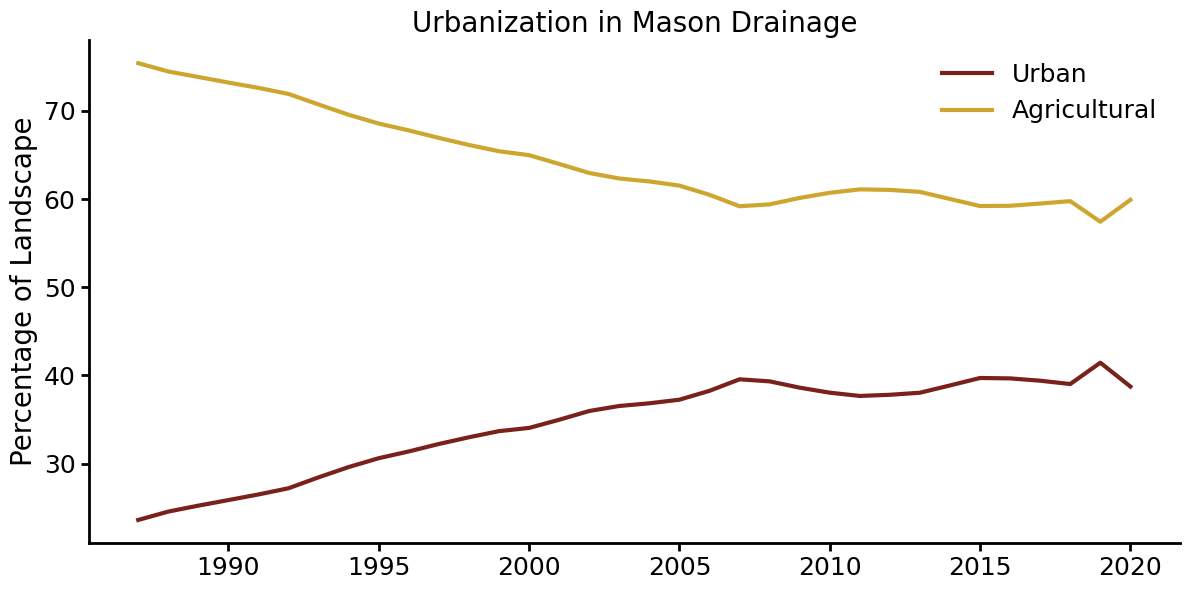

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_output/landcover_calculations_out/final_metrics/Mason Creek.csv')

years = file['dates']
urban = file['class1_urban']
crops = file['class2_crops']

def theme_cust(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', colors='black', width=2, length=6)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    return ax

plt.figure(figsize=(12, 6))

plt.plot(
    years,
    urban,
    label='Urban',
    color='#7A211B',
    linewidth=3,
    marker='o',
    markersize=0
)


plt.plot(
    years,
    crops,
    label='Agricultural',
    color='#CEA62F',
    linewidth=3,
    marker='o',
    markersize=0
)

ax = plt.gca()
ax.set_title("Urbanization in Mason Drainage", fontsize=20)
ax.set_xlabel("", fontsize=20)
ax.set_ylabel("Percentage of Landscape", fontsize=20)
ax.tick_params(axis='both', labelsize=18)
theme_cust(ax)

plt.legend(frameon=False, fontsize=18)
plt.tight_layout()
plt.show()